In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load simple dataset

We load the data from the UCR TS archive, you can get the data at http://www.cs.ucr.edu/~eamonn/time_series_data/

In [2]:
datapath = '/media/sf_VBox_Shared/timeseries/UCR_TS_Archive_2015'

In [3]:
datasets_train = {}
datasets_test = {}
for i in ["X", "Y", "Z"]:
    path_to_data_train = datapath + '/uWaveGestureLibrary_'+i+'/uWaveGestureLibrary_'+i+'_TRAIN'
    path_to_data_test = datapath + '/uWaveGestureLibrary_'+i+'/uWaveGestureLibrary_'+i+'_TEST'
    datasets_train[i] = np.genfromtxt(path_to_data_train, delimiter=',')
    datasets_test[i] = np.genfromtxt(path_to_data_test, delimiter=',')
    print(datasets_train[i].shape, datasets_test[i].shape)

(896, 316) (3582, 316)
(896, 316) (3582, 316)
(896, 316) (3582, 316)


In [4]:
y_train = np.vstack((datasets_train['X'][:,0], datasets_train['Y'][:,0], datasets_train['Z'][:,0])).transpose()
#Check labels are the same across channels
print(y_train.std(axis=1).sum())
y_train = np.array(y_train[:,0], dtype='int')
print(y_train.shape)

y_test = np.array(datasets_test['X'][:,0], dtype='int')
print(y_test.shape)

0.0
(896,)
(3582,)


In [5]:
X_train  = np.stack((datasets_train['X'][:,1:], datasets_train['Y'][:,1:], datasets_train['Z'][:,1:]), axis=-1)
print(X_train.shape)
X_test  = np.stack((datasets_test['X'][:,1:], datasets_test['Y'][:,1:], datasets_test['Z'][:,1:]), axis=-1)
print(X_test.shape)

(896, 315, 3)
(3582, 315, 3)


In [6]:
X_train[:3,:4,:]

array([[[-0.30424, -2.1194 , -1.529  ],
        [-0.30424, -2.1194 , -1.529  ],
        [-0.30424, -2.1194 , -1.529  ],
        [-0.30424, -2.1194 , -1.529  ]],

       [[ 1.6273 ,  0.66662,  1.7869 ],
        [ 1.6273 ,  0.66662,  1.7869 ],
        [ 1.6273 ,  0.66662,  1.7869 ],
        [ 1.6273 ,  0.66662,  1.7869 ]],

       [[ 0.66128, -0.18973,  0.52125],
        [ 0.66128, -0.18973,  0.52125],
        [ 0.66128, -0.18973,  0.52125],
        [ 0.66128, -0.18973,  0.52125]]])

In [7]:
#Change class labels ranging from 0 to n-1
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')

In [8]:
ntrain = X_train.shape[0]
num_training = int(ntrain * 0.7)
num_validation = ntrain - num_training
num_test = X_test.shape[0]

#First sort the data in random order
np.random.seed(123)
neworder = np.random.permutation(ntrain)
X_train_random = X_train[neworder,:]
y_train_random = y_train[neworder]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train_random[mask]
y_val = y_train_random[mask]
mask = range(num_training)
X_train = X_train_random[mask]
y_train = y_train_random[mask]


print(X_val.shape)

(269, 315, 3)


In [9]:
dim_length = X_train.shape[1]
dim_channels = X_train.shape[2]
outputdim = len(set(y_train))

In [10]:
# We need to convert the output
from keras.utils.np_utils import to_categorical
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)
print(y_train_binary[:10,:])

Using Theano backend.


[[ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]]


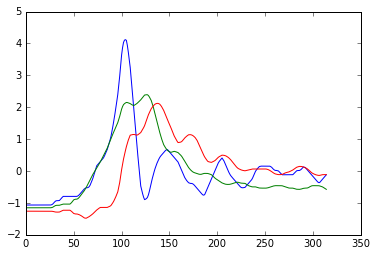

In [11]:
#plot example series
plt.plot(X_train[0,:]);

## Build model architecture

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D, BatchNormalization
from keras.regularizers import l2

In [20]:
filters = [64, 64, 64]
fc_hidden_nodes = 32
regularization_rate = 0.001
weightinit = 'lecun_uniform'
learning_rate = 0.0001

In [30]:
model = Sequential()
model.add(BatchNormalization(input_shape=(dim_length, dim_channels), mode=0, axis=2))
for filter_number in filters:
    model.add(Convolution1D(filter_number, 3, border_mode='same',
                            W_regularizer=l2(regularization_rate), init=weightinit))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(output_dim=fc_hidden_nodes,
                W_regularizer=l2(regularization_rate), init=weightinit))  # Fully connected layer
model.add(BatchNormalization())
model.add(Activation('relu'))  # Relu activation
model.add(Dense(output_dim=outputdim, init=weightinit))
model.add(Activation("softmax"))  # Final classification layer

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_8 (BatchNormal(None, 315, 3)        6           batchnormalization_input_5[0][0] 
____________________________________________________________________________________________________
convolution1d_10 (Convolution1D) (None, 315, 64)       640         batchnormalization_8[0][0]       
____________________________________________________________________________________________________
batchnormalization_9 (BatchNormal(None, 315, 64)       128         convolution1d_10[0][0]           
____________________________________________________________________________________________________
activation_16 (Activation)       (None, 315, 64)       0           batchnormalization_9[0][0]       
___________________________________________________________________________________________

Now we configure the learning process:

In [32]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])

In [45]:
print(X_train.mean(axis=(0,1)))
print(X_train.std(axis=(0,1)))

[ -2.24024966e-07   1.98264100e-07  -1.15843963e-07]
[ 0.9984117   0.99841144  0.99841141]


In [41]:
batchnormlay0 = model.layers[0]
batchnormlay1 = model.layers[2]
print(batchnormlay0.get_weights())
print('')
print(batchnormlay1.get_weights())

[array([ 0.99743915,  1.00168717,  1.0014627 ], dtype=float32), array([ 0.00158057,  0.00459987,  0.00098919], dtype=float32), array([ -2.47292661e-07,   1.41121973e-07,  -1.65971215e-07], dtype=float32), array([ 0.99841183,  0.99841172,  0.9984116 ], dtype=float32)]

[array([ 0.99996477,  1.00145125,  1.00089025,  0.99848485,  1.00060809,
        0.99864501,  1.00203156,  0.99856997,  0.99888021,  1.00242209,
        0.99878162,  1.00191188,  1.0011884 ,  1.00081849,  1.00210953,
        0.99843937,  1.00212812,  0.99687958,  1.0019294 ,  0.99712074,
        0.99873298,  0.99897206,  0.99783391,  1.00009191,  1.00108421,
        1.00039351,  1.00178754,  0.99776238,  1.00145888,  0.99806589,
        1.00121963,  0.99881822,  1.00004029,  1.00159848,  0.99924982,
        1.00158238,  1.00106978,  0.99996209,  1.00095022,  1.00035191,
        0.99909776,  0.99927467,  1.00103414,  1.00153375,  0.99967998,
        1.00079346,  0.99926901,  1.00208175,  0.99754316,  0.99759603,
        1.

## Fit the model on the data

In [33]:
model.fit(X_train, y_train_binary, nb_epoch=10, validation_data=(X_val, y_val_binary))

Train on 627 samples, validate on 269 samples
Epoch 1/10
627/627 [==============================] - 7s - loss: 1.3940 - acc: 0.6778 - val_loss: 0.8103 - val_acc: 0.8773
Epoch 2/10
627/627 [==============================] - 7s - loss: 0.9411 - acc: 0.9059 - val_loss: 0.6795 - val_acc: 0.9071
Epoch 3/10
627/627 [==============================] - 7s - loss: 0.8408 - acc: 0.9410 - val_loss: 0.6555 - val_acc: 0.9182
Epoch 4/10
627/627 [==============================] - 7s - loss: 0.7873 - acc: 0.9585 - val_loss: 0.6339 - val_acc: 0.9257
Epoch 5/10
627/627 [==============================] - 9s - loss: 0.7517 - acc: 0.9697 - val_loss: 0.6021 - val_acc: 0.9257
Epoch 6/10
627/627 [==============================] - 9s - loss: 0.7083 - acc: 0.9793 - val_loss: 0.5843 - val_acc: 0.9368
Epoch 7/10
627/627 [==============================] - 9s - loss: 0.6835 - acc: 0.9856 - val_loss: 0.5734 - val_acc: 0.9331
Epoch 8/10
627/627 [==============================] - 9s - loss: 0.6554 - acc: 0.9856 - val_l

## Validate the model on validation set

In [42]:
loss_and_metrics = model.evaluate(X_val, y_val_binary, batch_size=32)
loss_and_metrics

269/269 [==============================] - 0s     


[0.29719074574544968, 0.91821561382605688]

In [43]:
classes = model.predict_classes(X_val, batch_size=32)
proba = model.predict_proba(X_val, batch_size=32)

/home/dafne/anaconda2/envs/mcfly/lib/python3.5/site-packages/keras/backend/theano_backend.py:514: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


269/269 [==============================] - 0s     


In [44]:
print(np.hstack((proba, np.vstack((classes, y_val)).transpose())))

[[  9.94976819e-01   2.68205463e-06   1.38416353e-05 ...,   3.67989946e-06
    0.00000000e+00   0.00000000e+00]
 [  4.54686209e-08   5.07737896e-05   9.99749124e-01 ...,   1.04616440e-04
    2.00000000e+00   2.00000000e+00]
 [  1.37538869e-08   5.00898692e-04   9.98802483e-01 ...,   2.34044550e-04
    2.00000000e+00   2.00000000e+00]
 ..., 
 [  2.02587387e-03   9.11104376e-04   7.49258504e-07 ...,   3.05002788e-04
    5.00000000e+00   5.00000000e+00]
 [  2.96635553e-03   1.41996818e-04   4.06931895e-06 ...,   6.41167353e-05
    5.00000000e+00   5.00000000e+00]
 [  8.40993479e-08   9.99662817e-01   2.44735588e-06 ...,   9.40117206e-06
    1.00000000e+00   1.00000000e+00]]


Let's compute some more metrics, such as the confusion matrix and the ROC curve

In [45]:
from sklearn import metrics
metrics.confusion_matrix(classes, y_val)

array([[34,  0,  0,  1,  0,  5,  0,  0],
       [ 1, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 34,  0,  0,  2,  1,  0],
       [ 0,  0,  0, 25,  0,  1,  0,  0],
       [ 0,  0,  2,  2, 40,  1,  0,  0],
       [ 3,  0,  0,  1,  0, 28,  0,  0],
       [ 0,  1,  0,  0,  0,  1, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 25]])

## Test on testset

In [46]:
loss_and_metrics = model.evaluate(X_test, y_test_binary, batch_size=32)
loss_and_metrics

3582/3582 [==============================] - 1s     


[0.28670237241245261, 0.92238972621014637]

In [47]:
#Best score by Dynamic time warping:
1 - 0.034 

0.966